# Sparse Coding with Tensorflow
*Nhat Le, December 2017*

In [2]:
#import tensorflow as tf
import numpy as np
import pandas as pd
np.random.seed(0)

import matplotlib.pyplot as plt
import scipy.io.wavfile
import scipy.signal
import glob
import skimage.io
from sklearn.decomposition import PCA
import skimage.filters
import skimage.morphology
import seaborn as sns
import os.path
import sklearn.decomposition

from scipy.signal import convolve2d

%matplotlib inline

## Test NMF with Tensorflow

In [ ]:
A_orig = np.array([[3, 4, 5, 2],
                   [4, 4, 3, 3],
                   [5, 5, 4, 4]], dtype=np.float32).T

A_orig_df = pd.DataFrame(A_orig)

In [ ]:
A_df_masked = A_orig_df.copy()
A_df_masked.iloc[0,0]=np.NAN
np_mask = A_df_masked.notnull()

In [ ]:
np_mask

In [ ]:
# Boolean mask for computing cost only on valid (not missing) entries
tf_mask = tf.Variable(np_mask.values)

A = tf.constant(A_df_masked.values)
shape = A_df_masked.values.shape

#latent factors
rank = 3 

# Initializing random H and W
temp_H = np.random.randn(rank, shape[1]).astype(np.float32)
temp_H = np.divide(temp_H, temp_H.max())

temp_W = np.random.randn(shape[0], rank).astype(np.float32)
temp_W = np.divide(temp_W, temp_W.max())

H =  tf.Variable(temp_H)
W = tf.Variable(temp_W)
WH = tf.matmul(W, H)

In [ ]:
cost = tf.reduce_sum(tf.pow(tf.boolean_mask(A, tf_mask) - tf.boolean_mask(WH, tf_mask), 2))
# Learning rate
lr = 0.001
# Number of steps
steps = 1000
train_step = tf.train.GradientDescentOptimizer(lr).minimize(cost)
init = tf.global_variables_initializer()

In [ ]:
# Clipping operation. This ensure that W and H learnt are non-negative
clip_W = W.assign(tf.maximum(tf.zeros_like(W), W))
clip_H = H.assign(tf.maximum(tf.zeros_like(H), H))
clip = tf.group(clip_W, clip_H)

In [ ]:
steps = 1000
with tf.Session() as sess:
    sess.run(init)
    for i in range(steps):
        sess.run(train_step)
        sess.run(clip)
        if i%100==0:
            print("\nCost: %f" % sess.run(cost))
            print("*"*40)
    learnt_W = sess.run(W)
    learnt_H = sess.run(H)

In [ ]:
np.dot(learnt_W, learnt_H)

## Semi-seqNMF with song data

In [4]:
def logfsgram(X, N=1024, SR=8000, WIN=1024, NOV=512, FMIN=80, BPO=12):
    '''Create a spectrogram whose frequency is log-sampled
    X: signal X is input signal; N is parent FFT window; SR is the source samplerate.
    WIN is actual window length within FFT, NOV is number of overlapping 
    points between successive windows.
    Optional FMIN is the lowest frequency to display (80Hz);
    BPO is the number of bins per octave (12).
    MX returns the nlogbin x nfftbin mapping matrix;
    sqrt(MX'*(Y.^2)) is an approximation to the original FFT
    spectrogram that Y is based on, suitably blurred by going 
    through the log-F domain.
    Source: dpwe@ee.columbia.edu
'''
    _,_,XX = scipy.signal.spectrogram(X, fs=SR, nfft=WIN, nperseg=N, noverlap=NOV)
    fratio = 2.0**(1 / BPO)
    nbins = np.floor(np.log((SR / 2) / FMIN) / np.log(fratio))
    fftfrqs = np.arange(N/2 + 1) * (SR / N)
    nfftbins = N/2 + 1
    logffrqs = FMIN * np.exp(np.log(2) * np.arange(nbins) / BPO)
    logfbws = logffrqs * (fratio - 1)
    logfbws = np.maximum(logfbws, SR/N)
    ovfctr = 0.5475

    replogffrqs = np.repeat(logffrqs[:,np.newaxis], nfftbins, axis=1)
    repfftfrqs = np.tile(fftfrqs, (int(nbins), 1))
    replogfbws = np.repeat(ovfctr * logfbws[:,np.newaxis], nfftbins, axis=1)

    freqdiff = (replogffrqs - repfftfrqs) / replogfbws
    mx = np.exp(-0.5 * freqdiff**2)
    divby = np.sqrt(2 * np.sum(mx**2, axis=1))
    divby = np.repeat(divby[:,np.newaxis], nfftbins, axis=1)
    mx = mx / divby
    spectrogram = np.sqrt(np.dot(mx, np.abs(XX)**2))
    return spectrogram, XX, f, t



In [5]:
def read_song_file(type):
    '''Read song files of the appropriate type.
    Returns the combined sound and the sampling rate, fs'''
    if type == 'human':
        # Read the American English files
        soundfiles = glob.glob('./American-English/*/*.wav')
        sound_combined = np.zeros(0)
        for file in soundfiles:
            fs, sound = scipy.io.wavfile.read(file)
            sound_trim = np.trim_zeros(sound)
            sound_combined = np.concatenate((sound_combined, sound_trim))
    elif type == 'finch_50':
        # Read bird song file
        fs, sound_combined = scipy.io.wavfile.read('./songs_50_test_bird_0.15s.wav')
        sound_combined = sound_combined[:,0]
    elif type == 'finch_kail':
        # Read the finch songs by Kailey
        soundfiles = glob.glob('./Finch_songs/*song_2.wav')
        sound_combined = np.zeros(0)
        for file in soundfiles:
            print(file)
            fs, sound = scipy.io.wavfile.read(file)
            sound_trim = np.trim_zeros(sound)
            sound_combined = np.concatenate((sound_combined, sound_trim))
    elif type == 'pda':
        # Read the PDA data files
        soundfiles = glob.glob('./PDA/PDAm/16k/*/*_2.wav')[:20]
        sound_combined = np.zeros(0)
        for idx, file in enumerate(soundfiles):
            print('Reading file', idx, ' of ', len(soundfiles))
            fs, sound = scipy.io.wavfile.read(file)
            sound_combined = np.concatenate((sound_combined, sound))
    else:
        raise ValueError('Invalid file type')
        
    return sound_combined, fs

In [6]:
def make_spectrogram_multifile(type, id_start, id_end, nadvance, nperseg, slepian_len):
    if type == 'pda':
        # Read the PDA data files
        soundfiles = glob.glob('./PDA/PDAm/16k/*/*_5.wav')[id_start:id_end]
        t_all = np.zeros(0) # Used for time points in spectrogram
        thead = 0
        for idx, file in enumerate(soundfiles):
            print('Reading file', idx, ' of ', len(soundfiles))
            fs, sound = scipy.io.wavfile.read(file)
            f,t,spectrogram = multitaper_spec(sound, fs=fs, nadvance=nadvance, 
                                              nperseg=nperseg, slepian_len=slepian_len)
            t += thead
            t_all = np.append(t_all, t)
            if idx == 0:
                sound_combined = spectrogram
            else:
                sound_combined = np.hstack((sound_combined, spectrogram))
                
            thead += len(sound) / fs
    return fs, f, t_all, sound_combined

./Finch_songs\5014_song_2.wav
./Finch_songs\6280_song_2.wav
./Finch_songs\6288_song_2.wav
./Finch_songs\6419_song_2.wav
./Finch_songs\6876_song_2.wav
./Finch_songs\7101_song_2.wav
./Finch_songs\Pink1_song_2.wav
./Finch_songs\Pink2_song_2.wav
./Finch_songs\Pink3_song_2.wav
./Finch_songs\Pink4_song_2.wav
Error: file exists. Skipped writing


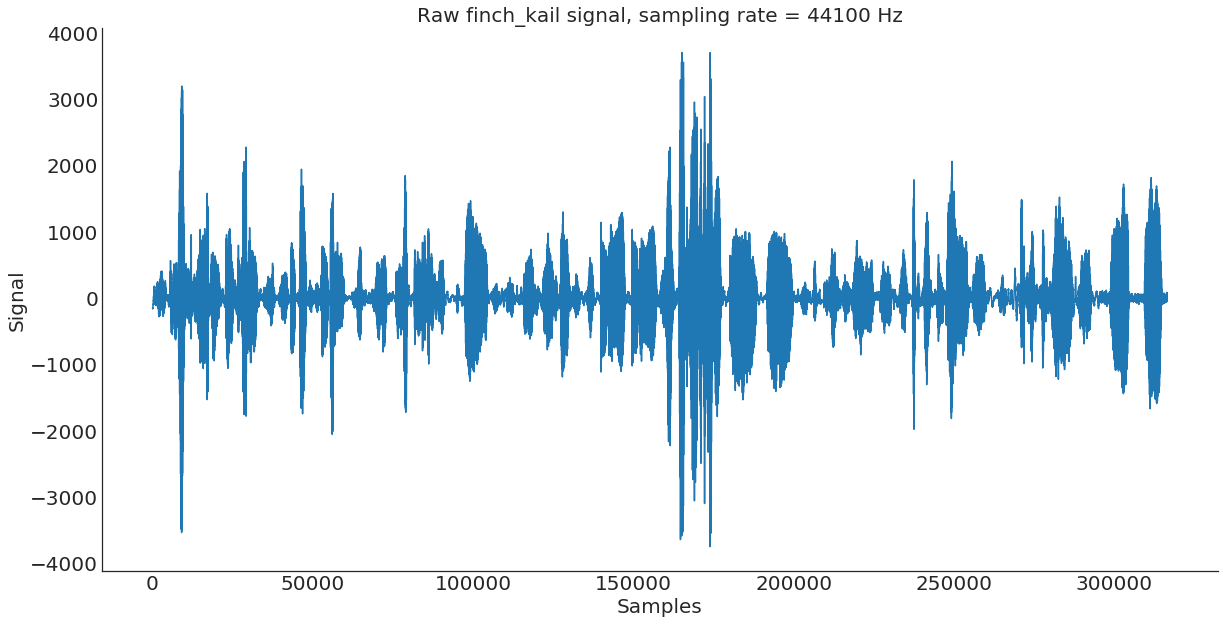

In [7]:
type = 'finch_kail'
with sns.axes_style('white'):
    plt.figure(figsize=(20, 10))
    sound_combined, fs = read_song_file(type)
    nsamples = len(sound_combined)
    sound_len_secs = nsamples / fs
    plt.plot(sound_combined)
    plt.xlabel('Samples', fontsize=20)
    plt.ylabel('Signal', fontsize=20)
    plt.title('Raw %s signal, sampling rate = %d Hz' % (type, fs), fontsize=20);
    sns.despine()
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
filename = 'waveform_human_171004.pdf'
if not os.path.isfile(filename):
    plt.savefig(filename)
else:
    print('Error: file exists. Skipped writing')

In [10]:
#p=TW determines spatial and temporal resolution
#k runs from 1,2,...2p-1, are the orthogonal modes which serve as 'samples' of the fft
def my_spectrogram(x):
    '''TODO: Implement multitapering with multiple dpss functions'''
    start = 0
    seg = sound_combined[start:start+nperseg]
    np.fft.fft(seg * window).shape

def multitaper_spec(X, fs, nadvance=100, slepian_len=500, nperseg=4096*4, NW=1):
    '''Perform a dpss multitapering
    Returns the spectrogram, frequency (f) and time ticks (t)'''

    # Use slepian window of width 0.3
    #window = scipy.signal.slepian(M=slepian_len, width=NW / slepian_len)
    window = scipy.signal.blackman(slepian_len)
    window = np.lib.pad(window, (0, nperseg - slepian_len), 'constant', constant_values=(0, 0))
    noverlap = len(window) - nadvance

    f,t,spectrogram = scipy.signal.spectrogram(X, fs, window=window, noverlap=noverlap)
    spectrogram = 20 * np.log10(spectrogram) #Units: dB
    
    return (f, t, spectrogram)

def sample_logspec(spectrogram, f, nsamples=256, fmin=100.0, fmax=4000.0):
    '''Sample the spectrogram to collect the required number of samples
    in frequency from fmin to fmax, logarithmically spaced
    Returns the spectrogram and the frequencies sampled'''
    # Frequencies to sample
    spacing = (np.log(fmax) - np.log(fmin)) / (nsamples - 1)
    logfreqs = np.log(fmin) + np.arange(nsamples) * spacing
    freqs = np.exp(logfreqs)
    
    # Sampled version
    row_ids = []
    for freq in freqs:
        row_ids.append(len(f[f < freq]))

    logspec = spectrogram[row_ids,:]
    return (logspec, freqs)

def format_func_spec(value, tick_number):
    '''Format tick marks for spectrogram plot'''
    if value >= len(freqs):
        label = max(freqs)
    else:
        label = freqs[int(value)]
    return int(np.round(label, -2))

def format_func_pcs(value, tick_number):
    '''Formatting axis ticks for the PC plot'''
    return value

def row_mean_subtract(mat):
    '''Subtract each row by its mean'''
    mat_mean = np.mean(mat, axis=1)
    mat_means = np.tile(mat_mean, (mat.shape[1], 1))
    return mat - mat_means.T

In [11]:
# Compute the spectrogram and log spectrogram
nadvance = 100
f,t,spectrogram = multitaper_spec(sound_combined, fs=fs, nadvance=nadvance)
logspec, freqs = sample_logspec(spectrogram, f, fmin=300.0, fmax=15000)

In [6]:
n_perseg = 4096*4
n_slep = 600
nadvance = 100
fs, f, t, spectrogram = make_spectrogram_multifile('pda', 0, 10, nadvance=nadvance, 
                                                   nperseg=n_perseg, slepian_len=n_slep)
logspec, freqs = sample_logspec(spectrogram, f, fmin=100.0, fmax=4000)


Reading file 0  of  10
Reading file 1  of  10
Reading file 2  of  10
Reading file 3  of  10
Reading file 4  of  10
Reading file 5  of  10
Reading file 6  of  10
Reading file 7  of  10
Reading file 8  of  10
Reading file 9  of  10


Error: file exists. Skipped writing


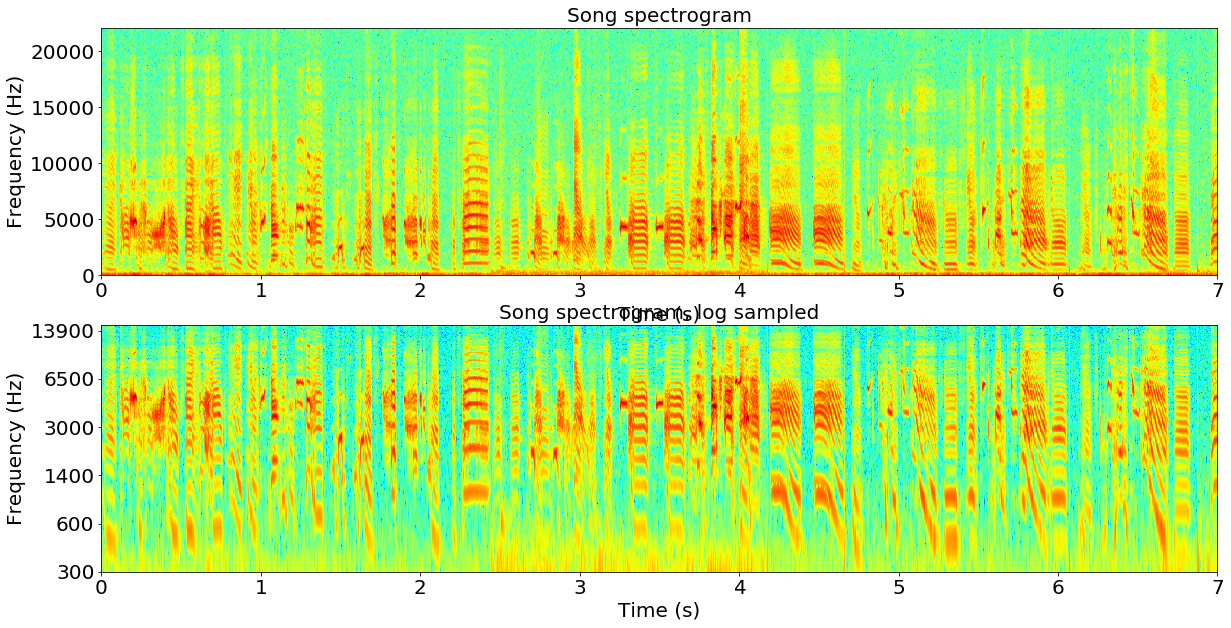

In [12]:
# Time and frequency ranges for plotting
fmin = 0
fmax = np.max(f) #Hz
tmin = 0
tmax = 7 #s
f_start = len(f[f<fmin])
f_end = len(f[f<fmax])
t_start = len(t[t<tmin])
t_end = len(t[t<tmax])


# Plot the spectrogram and log spectrogram
fig, ax = plt.subplots(2, 1, figsize=(20,10))
ax[0].imshow(np.flipud(spectrogram[f_start:f_end,t_start:t_end]), cmap='jet', aspect='auto',
           extent=[tmin, tmax, fmin, fmax])
ax[0].grid(False)
ax[0].set_title('Song spectrogram', fontsize=20)
ax[0].set_xlabel('Time (s)', fontsize=20)
ax[0].set_ylabel('Frequency (Hz)', fontsize=20);
ax[0].tick_params(axis='both', which='major', labelsize=20)

# For plotting
ax[1].imshow(np.flipud(logspec[:,t_start:t_end]), cmap='jet', aspect='auto',
           extent=[tmin, tmax, 0, len(freqs)])
ax[1].grid(False)
ax[1].set_title('Song spectrogram, log sampled', fontsize=20)
ax[1].set_xlabel('Time (s)', fontsize=20)
ax[1].set_ylabel('Frequency (Hz)', fontsize=20);
ax[1].yaxis.set_major_formatter(plt.FuncFormatter(format_func_spec))
ax[1].tick_params(axis='both', which='major', labelsize=20)

filename = 'spectrogram_human_171004.pdf'
if not os.path.isfile(filename):
    plt.savefig(filename)
else:
    print('Error: file exists. Skipped writing')

In [13]:
segment_len

NameError: name 'segment_len' is not defined

In [14]:
# Segment into overlapping segments
spectrogram = logspec
segment_len_ms = 50
segment_len = int(segment_len_ms / 1000 / nadvance * fs) #samples

n_comp_pca = 200
segment_width = spectrogram.shape[0]
segment_step = int(segment_len / 10) #samples
dt = segment_len * nadvance / fs * 1000 #length of each window in ms
segments_lst = []
for t_start in np.arange(0, spectrogram.shape[1] - segment_len, segment_step):
    segments_lst.append(spectrogram[:,t_start:(t_start + segment_len)])
    
# Do pca on each segment
X = np.zeros((segments_lst[0].shape[0] * segments_lst[0].shape[1], len(segments_lst)))
for idx, segment in enumerate(segments_lst):
    X[:,idx] = segment.ravel()    

# Mean subtract TODO: Test validity
#Xmean = np.mean(X, axis=1)
#Xmeans = np.tile(Xmean, (X.shape[1], 1))
#X1 = X - Xmeans.T
X1 = row_mean_subtract(X)

# Perform pca with whitening
pca = PCA(n_components=n_comp_pca, whiten=True)
pca.fit(X1.T)
Y = pca.transform(X1.T).T 

print('Number of segments:', Y.shape[1])

Number of segments: 1490


Error: file exists. Skipped writing


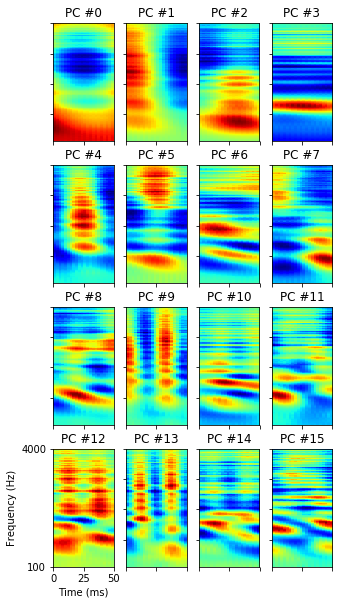

In [15]:
# Visualize principal components
n_show = 4 #number of rows to show. will show n_show x n_show pca components
fig, ax = plt.subplots(n_show, n_show, figsize=(5,10))
comp = pca.components_

for i in range(n_show):
    for j in range(n_show):
        idx = n_show*i + j
        component = comp[idx,:].reshape((segment_width, segment_len))
        ax[i][j].grid(False)
        ax[i][j].imshow(np.flipud(component), cmap='jet', aspect='auto', extent=[0, dt, 100, 4000])
        ax[i][j].set_title('PC #' + str(idx))
        ax[i][j].set_ylim([100, 4000])
        if i != n_show - 1 or j != 0:
            ax[i][j].set(xticklabels=[], yticklabels=[])
        else:
            ax[i][j].set_xlabel('Time (ms)')
            ax[i][j].set_ylabel('Frequency (Hz)')
            ax[i][j].yaxis.set_major_locator(plt.FixedLocator([100, 4000]))
            ax[i][j].yaxis.set_major_formatter(plt.FuncFormatter(format_func_pcs))

filename = 'PCs_finch_kail_171009.pdf'
if not os.path.isfile(filename):
    plt.savefig(filename)
else:
    print('Error: file exists. Skipped writing')

## Semi-CNMF

In [16]:
def shift_mat(A, number, direction='right'):
    assert(number <= A.shape[1] and number >= 0)
    if direction == 'right':
        return np.hstack((np.zeros((A.shape[0], number)), 
                              A[:, :A.shape[1] - number]))
    elif direction == 'left':
        return np.hstack((A[:, number:], np.zeros((A.shape[0], number))))
    
    
def conv2(x, y, mode='same'):
    return np.rot90(convolve2d(np.rot90(x, 2), np.rot90(y, 2), mode=mode), 2)

def reconstruct_from_decomposition(W, H):
    '''W is N x K x L np array (neurons x factors x lags)
    H is K x T np array (factors x time)
    Output: N x T np array (neurons x time), the reconstruction'''
    m, num_basis_elems, num_frames = W.shape
    n = H.shape[1]
    assert(n >= num_frames)
    Vhat = np.zeros((m, n))
    for t in range(num_frames):
        Hshifted = shift_mat(H, t, 'right')
        Vhat = Vhat + np.dot(W[:, :, t], Hshifted)
    return Vhat

In [17]:
V = logspec

# Perform semi-cnmf on V
num_basis_elems = 100
context_len = 20
lambdaW = 0.00001

# Initialize W and H
W = np.random.random((V.shape[0], num_basis_elems, context_len))
H = np.random.random((num_basis_elems, V.shape[1]))
m, n = V.shape

maxiter = 100
smoothkernel = np.ones((1, 2 * context_len - 1))

for iter in range(maxiter):
    print(iter)
    # Update W
    for t in range(context_len):
        #from IPython.core.debugger import Tracer; Tracer()()    
        H_shifted = shift_mat(H, t, 'right')
        numerator = np.dot(V, H_shifted.T)
        denominator = np.dot(H_shifted, H_shifted.T)
        W[:, :, t] = np.dot(numerator, np.linalg.inv(denominator))
        
    # Normalize
    for k in range(num_basis_elems):
        w_norm = np.linalg.norm(W[:, k, :]) / context_len
        W[:, k, :] /= w_norm
        H[k, :] *= w_norm
    
    
    # Update H
    H_temp = np.zeros_like(H)
    
    # Factor competition
    negative_grad = np.zeros((num_basis_elems, n))
    for t in range(context_len):
        V_shifted = shift_mat(V, t, 'left')
        negative_grad = negative_grad + np.dot(W[:, :, t].T, V_shifted)
        
    smXW = conv2(negative_grad, smoothkernel, 'same')
    FC2 = lambdaW * np.dot(1 - np.identity(smXW.shape[0]), smXW)
    FC2_pos = 0.5 * (np.abs(FC2) + FC2)
    FC2_neg = 0.5 * (np.abs(FC2) - FC2)
    
    
    #from IPython.core.debugger import Tracer; Tracer()()  
    for t in range(context_len):     
        
        V_shifted = shift_mat(V, t, 'left')
        Wslice = W[:, :, t]
        WVmat = np.dot(Wslice.T, V_shifted)
        WWmat = np.dot(Wslice.T, Wslice)
        W_V_pos = 0.5 * (np.abs(WVmat) + WVmat)
        W_V_neg = 0.5 * (np.abs(WVmat) - WVmat)
        W_W_pos = 0.5 * (np.abs(WWmat) + WWmat)
        W_W_neg = 0.5 * (np.abs(WWmat) - WWmat)
        single_update = H * np.sqrt((W_V_pos + np.dot(W_W_neg, 
                                H) + FC2_neg) / (W_V_neg + np.dot(W_W_pos, H) + FC2_pos + 1e-10))
        
        H_temp += single_update
    H = H_temp / context_len


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


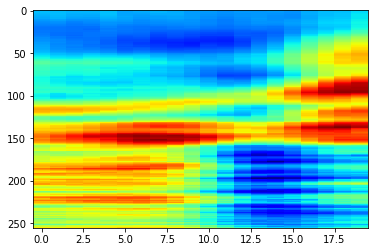

In [18]:
plt.imshow(W[:, 10, :], aspect='auto', cmap='jet')


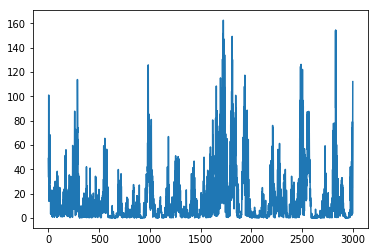

In [22]:
plt.plot(H[2,:])

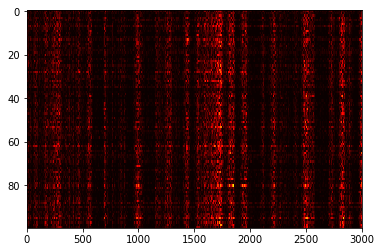

In [23]:
plt.imshow(H, aspect='auto', cmap='hot')

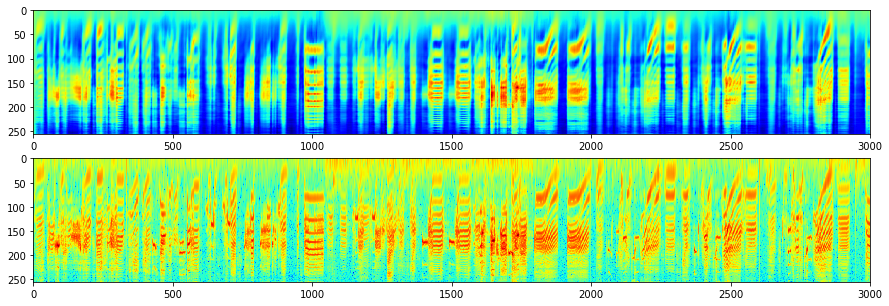

In [24]:
fig, ax = plt.subplots(2, 1, figsize=(15, 5))
ax[0].imshow(reconstruct_from_decomposition(W, H), aspect='auto', cmap='jet')
ax[0].grid(False)
ax[1].imshow(V,aspect='auto', cmap='jet')
ax[1].grid(False)

Error: file exists. Skipped writing


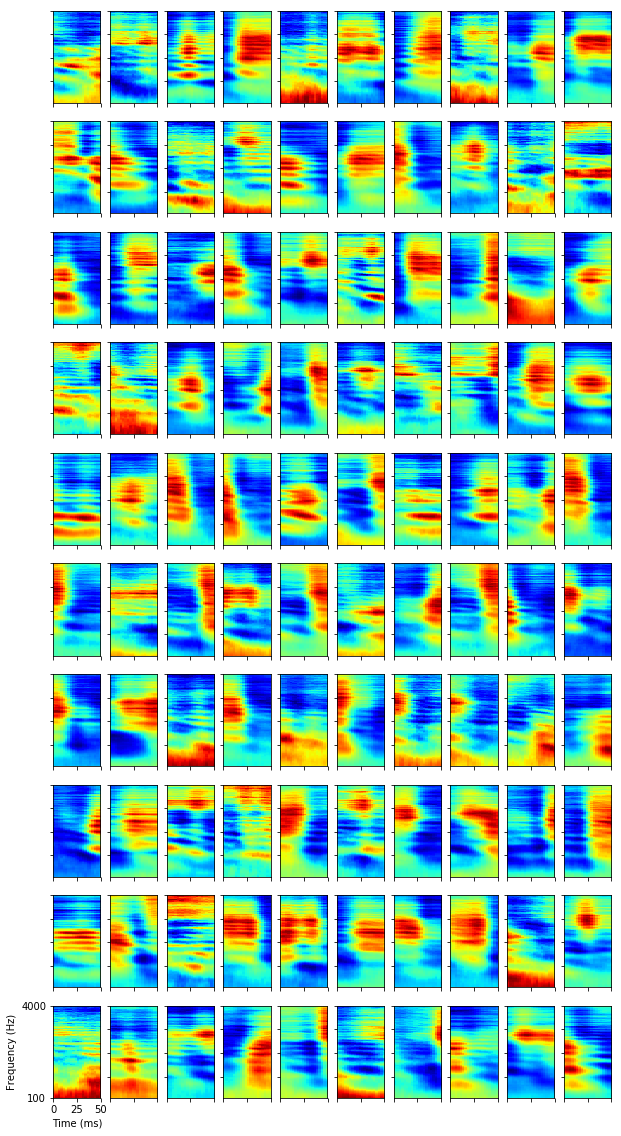

In [25]:
nrows = 10
ncols = 10
#A_inverted = pca.inverse_transform(best_A.T).T
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols,2 * nrows))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None,
            wspace=None, hspace=None)
strfs_all = []


for i in range(nrows):
    for j in range(ncols):
       
        filt = W[:, nrows * i + j, :]
        skew = scipy.stats.skew(filt.ravel())
        if skew < 0:
            filt *= -1
        
        idx = n_show*i + j
        ax[i][j].grid(False)
        ax[i][j].imshow(np.flipud(filt), cmap='jet', aspect='auto', extent=[0, dt, 100, 4000])
        #ax[i][j].c
        #ax[i][j].set_yscale('log')
        #ax[i][j].set_title('Neuron #' + str(idx))
        ax[i][j].set_ylim([100, 4000])
        if i != nrows - 1 or j != 0:
            ax[i][j].set(xticklabels=[], yticklabels=[])
        else:
            ax[i][j].set_xlabel('Time (ms)')
            ax[i][j].set_ylabel('Frequency (Hz)')
            #ax[i][j].yaxis.set_major_locator(plt.LogLocator(numticks=5))
            ax[i][j].yaxis.set_major_locator(plt.FixedLocator([100, 4000]))
            ax[i][j].yaxis.set_major_formatter(plt.FuncFormatter(format_func_pcs)) 
filename = 'receptive_fields_pda30_102417_200pcs_150neurons_L1_modified.pdf'
if not os.path.isfile(filename):
    plt.savefig(filename)
else:
    print('Error: file exists. Skipped writing')

In [34]:
x = sklearn.decomposition.dict_learning(Ysmall.T, 150, 
                                                       0.5, max_iter=100, tol=1e-08, 
                                                       method='lars', n_jobs=1, dict_init=None, 
                                                       code_init=None, callback=None, verbose=True, 
                                                       random_state=None, return_n_iter=False)

[dict_learning] ....................................................................................................

In [35]:
code = x[0]
dict = x[1]
errors = x[2]

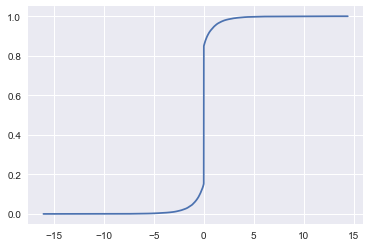

In [58]:
codevec = code.ravel()
plt.plot(np.sort(codevec), np.arange(len(codevec))/ len(codevec));

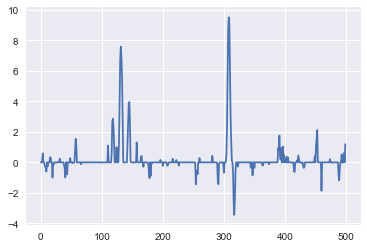

In [55]:
plt.plot(code[:,0])

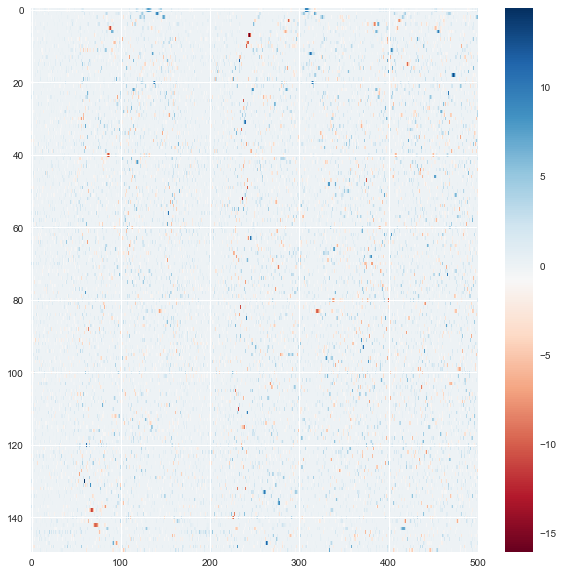

In [51]:
plt.figure(figsize=(10, 10))
plt.imshow(code.T, cmap='RdBu', aspect='auto')
plt.colorbar()

In [23]:
code.shape

(200, 150)

In [24]:
dict.shape

(150, 500)

In [65]:
X = np.array([[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12]])
norms = np.linalg.norm(X, axis=0)
X / norms

array([[ 0.09667365,  0.16903085,  0.22423053,  0.26726124],
       [ 0.48336824,  0.50709255,  0.52320456,  0.53452248],
       [ 0.87006284,  0.84515425,  0.8221786 ,  0.80178373]])

In [107]:
#latent factors
rank = 100 

# Initializing random H and W
temp_H = np.random.randn(rank, shape[1]).astype(np.float64)
temp_H = np.divide(temp_H, temp_H.max())

temp_W = np.random.randn(shape[0], rank).astype(np.float64)
temp_W = np.divide(temp_W, temp_W.max())

H =  tf.Variable(temp_H)
W = tf.Variable(temp_W)

norms = tf.norm(W, axis=0)
W = W / norms

WH = tf.matmul(W, H)
corr = tf.matmul(tf.transpose(W), W)

l1_regularizer = tf.contrib.layers.l1_regularizer(
   scale=lamb * 1.0, scope=None
)
regularization_penalty = tf.contrib.layers.apply_regularization(l1_regularizer, [H])

In [114]:
lamb = 1
theta = 1
cost = tf.reduce_sum(tf.pow(A - WH, 2)) + lamb * tf.norm(H, ord=1) + \
    theta * tf.reduce_sum(tf.pow(corr, 2))
# Learning rate
lr = 0.0001

#clip_W = W.assign(tf.maximum(tf.zeros_like(W), W))
clip_H = H.assign(tf.maximum(tf.zeros_like(H), H))
#clip = tf.group(clip_H)

# Number of steps
steps = 10
train_step = tf.train.GradientDescentOptimizer(lr).minimize(cost)
init = tf.global_variables_initializer()

In [115]:
steps = 1000
with tf.Session() as sess:
    sess.run(init)
    for i in range(steps):
        sess.run(train_step)
        #sess.run(clip_H)
        if i%100==0:
            print("\nCost: %f" % sess.run(cost))
            print("*"*40)
    learnt_W = sess.run(W)
    learnt_H = sess.run(H)


Cost: 516665.349524
****************************************

Cost: 497486.721265
****************************************

Cost: 482795.481573
****************************************

Cost: 471838.295912
****************************************

Cost: 463450.131407
****************************************

Cost: 456715.478538
****************************************

Cost: 451061.703349
****************************************

Cost: 446146.678258
****************************************

Cost: 441781.363178
****************************************

Cost: 437849.256428
****************************************


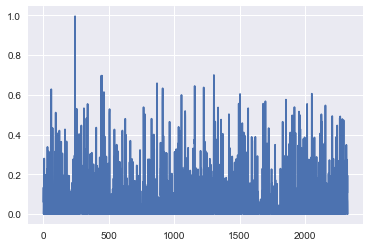

In [123]:
plt.plot(learnt_H[0,:])

In [124]:
np.sum(learnt_H ==0) / 310800

0.37426962676962677

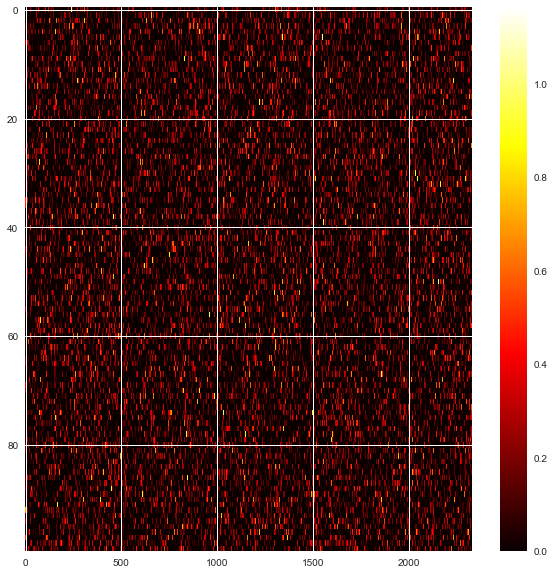

In [121]:
plt.figure(figsize=(10, 10))
learnt_H[learnt_H < 0] = 0
plt.imshow(learnt_H, 
           aspect='auto', cmap='hot')
plt.colorbar()

Error: file exists. Skipped writing


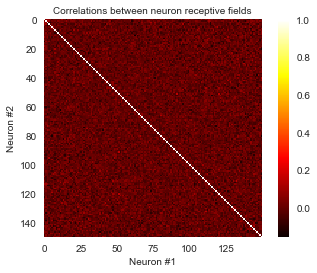

In [42]:
# Check the orthogonality of neurons
best_A = dict.T

corr = np.dot(best_A.T, best_A)
#A_inv = np.dot(comp.T, best_A)
#corr = np.dot(A_inv.T, A_inv)
plt.imshow(corr, cmap='hot')
plt.grid(False)
plt.colorbar()
#plt.clim(0, 1)
plt.title('Correlations between neuron receptive fields', fontsize=10)
plt.xlabel('Neuron #1', fontsize=10)
plt.ylabel('Neuron #2', fontsize=10)

filename = 'correlations_human_171005.pdf'
if not os.path.isfile(filename):
    plt.savefig(filename)
else:
    print('Error: file exists. Skipped writing')

Error: file exists. Skipped writing


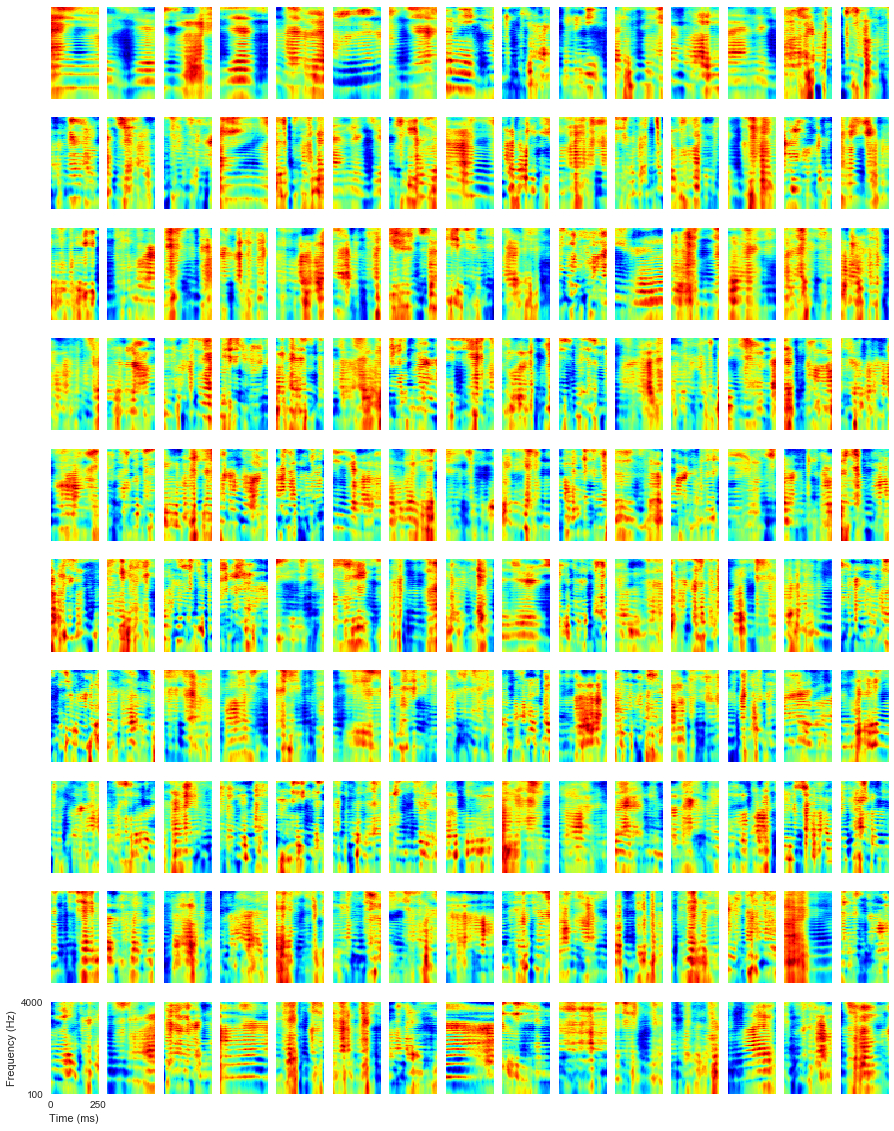

In [49]:
nrows = 10
ncols = 15
A_inverted = pca.inverse_transform(best_A.T).T
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols,2 * nrows))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None,
            wspace=None, hspace=None)
strfs_all = []


for i in range(nrows):
    for j in range(ncols):
        A_col = best_A[:,ncols*i + j]
        A_col_inv = pca.inverse_transform(A_col)
        A_inv_im = np.reshape(A_col_inv, (segment_width, segment_len))
        #seg = A_inverted[:,n_show*i + j].reshape((segment_width, segment_len))
        #A_inv_im /= np.max(np.abs(A_inv_im))
        
        # Invert if skew is negative
        skew = scipy.stats.skew(A_inv_im.ravel())
        if skew > 0:
            A_inv_im *= -1
        
        # Filter
        selem = skimage.morphology.disk(2)

        #filt = skimage.filters.rank.mean_percentile(A_inv_im, selem=selem, p0=.1, p1=.9)
        #filt = skimage.filters.rank.mean_bilateral(A_inv_im, selem=selem, s0=500, s1=500)
        #filt = skimage.filters.rank.mean(A_inv_im, selem=selem)
        #filt = filt / np.max(np.abs(filt))
        #filt = scipy.ndimage.filters.median_filter(A_inv_im, size=5)
        #filt = scipy.ndimage.filters.gaussian_filter(filt, sigma=2)
        filt = A_inv_im        
        
        idx = n_show*i + j
        ax[i][j].grid(False)
        ax[i][j].imshow(np.flipud(filt), cmap='jet', aspect='auto', extent=[0, dt, 100, 4000])
        #ax[i][j].c
        #ax[i][j].set_yscale('log')
        #ax[i][j].set_title('Neuron #' + str(idx))
        ax[i][j].set_ylim([100, 4000])
        if i != nrows - 1 or j != 0:
            ax[i][j].set(xticklabels=[], yticklabels=[])
        else:
            ax[i][j].set_xlabel('Time (ms)')
            ax[i][j].set_ylabel('Frequency (Hz)')
            #ax[i][j].yaxis.set_major_locator(plt.LogLocator(numticks=5))
            ax[i][j].yaxis.set_major_locator(plt.FixedLocator([100, 4000]))
            ax[i][j].yaxis.set_major_formatter(plt.FuncFormatter(format_func_pcs)) 
filename = 'receptive_fields_pda30_102417_200pcs_150neurons_L1_modified.pdf'
if not os.path.isfile(filename):
    plt.savefig(filename)
else:
    print('Error: file exists. Skipped writing')

In [45]:
np.max(filt)

6.1668093939167434